In [39]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [4]:
file1 = pd.ExcelFile('../01_Data/160701-Answers-to-QON-856-60.xlsx')
file2 = pd.ExcelFile('../01_Data/Copy-of-Census-2011-LAC-Demographic-Data-3.xlsx')

In [5]:
df = pd.DataFrame()

for isheet in file1.sheet_names:
    if 'LAC' in isheet:
        to_append = file1.parse(sheetname=isheet)
        to_append['Sheet'] = isheet
        df = pd.concat([df,to_append])
        
df['LAC'] = df['LAC'].str.upper()

In [6]:
df.loc[
    (df['LAC'].isin([
                'CAMDEN','COOTAMUNDRA','GRIFFITH','MUDGEE','QUAKERS HILL','RICHMOND'
            ])), 'LAC'
] = df.loc[
    (df['LAC'].isin([
                'CAMDEN','COOTAMUNDRA','GRIFFITH','MUDGEE','QUAKERS HILL','RICHMOND'
            ])), 'LAC'
] + ' LAC'

df.loc[
    (df['LAC']=='SYDNEY CITY'), 'LAC'
] = 'CITY CENTRAL'

In [307]:
NSW = pd.read_csv('../01_Data/NSW_all_measures_LAC.csv')

metadata = pd.ExcelFile('../01_Data/NSW_2011/Metadata/Metadata_2011_PEP_DataPack.xlsx'
                       ).parse(sheetname='Table Number, Name, Population', skiprows=2)

metadata = metadata[metadata['Table number'].isin([
            'P01','P06','P07','P08','P10','P11','P13','P16','P17','P28','P32'
        ])]

nsw = NSW[['LAC']+[col for col in NSW.columns.values if col.split('|')[0] in metadata['Table number'].values]]

inner = df.merge(nsw,how="inner")
inner = inner[inner['Sheet']!='LAC Totals'].drop(['2014','2015','2016 to date','Unnamed: 5','Unnamed: 6'], axis=1)

inner_2015 = inner[inner['Sheet'] == 'LAC 2015']



inner_2015['Searches_per_hundred'] = inner_2015['Total']/inner_2015['P01|Tot_P_P']*100

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [308]:
inner_2015['AGG|indig_%_of_pop'] = inner_2015[
    [
        col for col in inner_2015.columns.values if 'Indig_status_ns_P' in col and
        any(['20_24' in col,'25_29' in col, '30_34' in col])
    ]
].sum(axis=1)/inner_2015['P01|Tot_P_P']*100

for col in [
        col for col in inner_2015 if 'P28|' in col if '_Tot' in col and '_Inc' not in col and 'Tot_Tot' not in col
    and 'sum_prod' not in col
    ]:
    if col == 'P28|Inc_4000orMore_Tot':
        inner_2015[col+'sum_prod'] = inner_2015[col] * 5500
    elif col == 'P28|Tot_Tot':
        None
    else:
        inner_2015[col+'sum_prod'] = inner_2015[col] * (int(col.split('_')[1]) + int(col.split('_')[2])) / 2
        
inner_2015['AGG|Average_Hhold_Income_000s'] = inner_2015[
    [col for col in inner_2015 if 'sum_prod' in col]
].sum(axis=1) / inner_2015['P28|Tot_Tot'] / 1000

inner_2015['Income_Dist'] = inner_2015[
    [col for col in inner_2015 if 'P28|' in col if '_Tot' in col and '_Inc' not in col and 'Tot_Tot' not in col]
].std(axis=1)

inner_2015['AGG|Tourists_per_cap'] = inner_2015['P01|OS_vis_P'] / inner_2015['P01|Tot_P_P']

inner_2015['AGG|CALD_%'] = inner_2015[[
    col for col in inner_2015 if 'P13|' in col 
    and col[-2:] == '_P' 
    and any((i in col) for i in ['Tamil','Thai','Iranic_Lang_Oth','Turkish'])
]].sum(axis=1) / inner_2015['P01|Tot_P_P'] * 100

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [309]:
inner_2015['Const'] = 1

#inner_2015 = inner_2015[inner_2015['Searches_per_hundred'] < 1]

model = sm.OLS(inner_2015['Searches_per_hundred'],
               inner_2015[
        [
            'Const','AGG|indig_%_of_pop',
         'AGG|Average_Hhold_Income_000s',
         'AGG|Tourists_per_cap',
         #'AGG|CALD_%'
        ]
    ]
              )

results = model.fit()

results.summary()

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Searches_per_hundred   R-squared:                       0.888
Model:                              OLS   Adj. R-squared:                  0.883
Method:                   Least Squares   F-statistic:                     185.3
Date:                  Wed, 12 Oct 2016   Prob (F-statistic):           3.19e-33
Time:                          07:11:31   Log-Likelihood:                 31.587
No. Observations:                    74   AIC:                            -55.17
Df Residuals:                        70   BIC:                            -45.96
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Const                             0.0382      0.082      0.468      0.641        -0.125     0.201
AGG|indig_%_of_pop                0.2502      0.030      8.229      0.000         0.190     0.311
AGG|Average_Hhold_Income_000s    -0.1346      0.063     -2.128      0.037        -0.261    -0.008
AGG|Tourists_per_cap              7.8942      2.054      3.843      0.000         3.797    11.991
==============================================================================
Omnibus:                        6.180   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.234
Skew:                           0.435   Prob(JB):                       0.0443
Kurtosis:                       4.124   Cond. No.                         260.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [290]:
inner_2015['Const'] = 1

#inner_2015 = inner_2015[inner_2015['Searches_per_hundred'] < 1]

model = sm.OLS(inner_2015['Searches_per_hundred'],
               inner_2015[
        [
            'Const','AGG|indig_%_of_pop',
         'AGG|Average_Hhold_Income_000s',
         'AGG|Tourists_per_cap',
         #'AGG|CALD_%'
        ]
    ]
              )

results = model.fit()

results.summary()

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Searches_per_hundred   R-squared:                       0.888
Model:                              OLS   Adj. R-squared:                  0.883
Method:                   Least Squares   F-statistic:                     185.3
Date:                  Wed, 12 Oct 2016   Prob (F-statistic):           3.19e-33
Time:                          07:00:01   Log-Likelihood:                 31.587
No. Observations:                    74   AIC:                            -55.17
Df Residuals:                        70   BIC:                            -45.96
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Const                             0.0382      0.082      0.468      0.641        -0.125     0.201
AGG|indig_%_of_pop                0.2502      0.030      8.229      0.000         0.190     0.311
AGG|Average_Hhold_Income_000s    -0.1346      0.063     -2.128      0.037        -0.261    -0.008
AGG|Tourists_per_cap              7.8942      2.054      3.843      0.000         3.797    11.991
==============================================================================
Omnibus:                        6.180   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.234
Skew:                           0.435   Prob(JB):                       0.0443
Kurtosis:                       4.124   Cond. No.                         260.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [289]:
inner_2015['Const'] = 1

inner_2015_2 = inner_2015[inner_2015['Searches_per_hundred'] < 1]

model = sm.OLS(inner_2015_2['Searches_per_hundred'],
               inner_2015_2[
        ['Const','AGG|indig_%_of_pop',
         'AGG|Average_Hhold_Income_000s',
         #'AGG|Tourists_per_1000_residents',
         'AGG|CALD_%']
    ]
              )

results = model.fit()

results.summary()

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Searches_per_hundred   R-squared:                       0.289
Model:                              OLS   Adj. R-squared:                  0.255
Method:                   Least Squares   F-statistic:                     8.659
Date:                  Wed, 12 Oct 2016   Prob (F-statistic):           6.62e-05
Time:                          06:59:43   Log-Likelihood:                 36.289
No. Observations:                    68   AIC:                            -64.58
Df Residuals:                        64   BIC:                            -55.70
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Const                             0.0679      0.075      0.900      0.371        -0.083     0.219
AGG|indig_%_of_pop                0.1082      0.046      2.348      0.022         0.016     0.200
AGG|Average_Hhold_Income_000s    -0.0471      0.061     -0.769      0.445        -0.169     0.075
AGG|CALD_%                        0.0435      0.016      2.659      0.010         0.011     0.076
==============================================================================
Omnibus:                       24.721   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.898
Skew:                           1.254   Prob(JB):                     1.08e-10
Kurtosis:                       6.147   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [288]:
inner_2015[
    ['Searches_per_hundred','Model_prediction']
].corr()

,Searches_per_hundred,Model_prediction
Searches_per_hundred,1.00000,0.44719
Model_prediction,0.44719,1.00000


/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


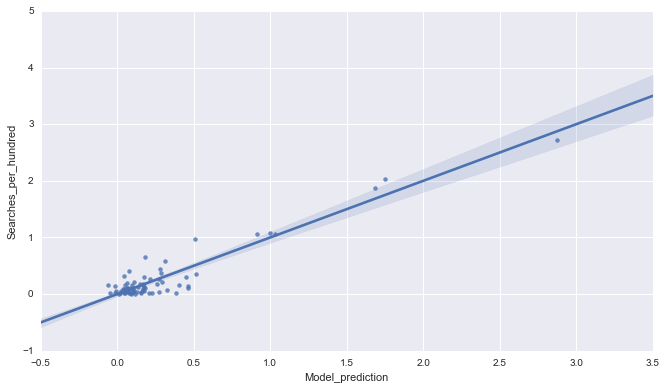

In [291]:
inner_2015['Model_prediction'] = results.fittedvalues
inner_2015['error'] = inner_2015['Searches_per_hundred'] - inner_2015['Model_prediction']
inner_2015['error_sq'] = inner_2015['error'] * inner_2015['error']
inner_2015['error_weighted'] = inner_2015['error'] / inner_2015['Searches_per_hundred']

sns.lmplot(data=inner_2015.sort_values(by='Searches_per_hundred'), 
           y='Searches_per_hundred', x='Model_prediction', size=5.5, aspect=1.7)

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


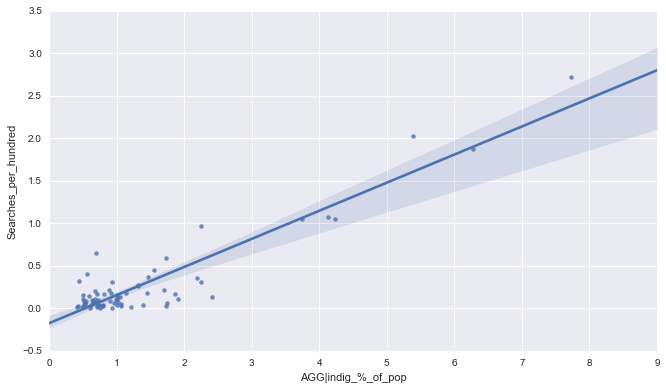

In [281]:
sns.lmplot(data=inner_2015, y='Searches_per_hundred', x='AGG|indig_%_of_pop', size=5.5, aspect=1.7)

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


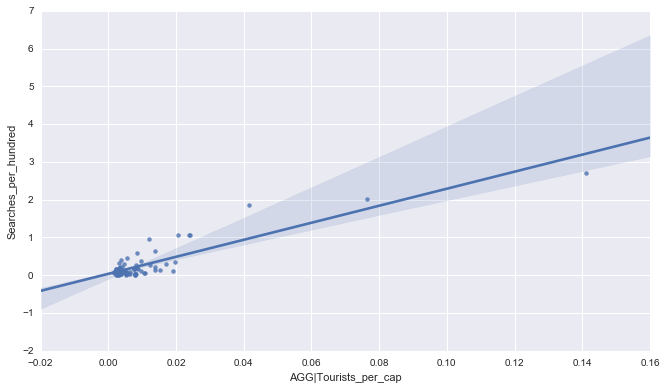

In [300]:
sns.lmplot(data=inner_2015, y='Searches_per_hundred', x='AGG|Tourists_per_cap', size=5.5, aspect=1.7)

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


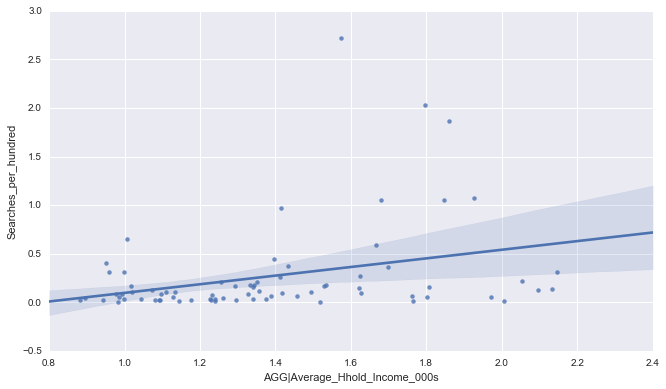

In [283]:
sns.lmplot(data=inner_2015, y='Searches_per_hundred', x='AGG|Average_Hhold_Income_000s', size=5.5, aspect=1.7)

In [120]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Searches_per_thousand   R-squared:                       0.888
Model:                               OLS   Adj. R-squared:                  0.883
Method:                    Least Squares   F-statistic:                     185.3
Date:                   Tue, 11 Oct 2016   Prob (F-statistic):           3.19e-33
Time:                           16:06:29   Log-Likelihood:                -138.80
No. Observations:                     74   AIC:                             285.6
Df Residuals:                         70   BIC:                             294.8
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Const                    0.3823      0.817      0.468      0.641        -1.247     2.012
SUM|indig_status_p       2.5022      0.304      8.229      0.000         1.896     3.109
Ave_Inc_Est             -0.0013      0.001     -2.128      0.037        -0.003 -8.47e-05
proportional_tourism    78.9421     20.543      3.843      0.000        37.970   119.914
==============================================================================
Omnibus:                        6.180   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.234
Skew:                           0.435   Prob(JB):                       0.0443
Kurtosis:                       4.124   Cond. No.                     1.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

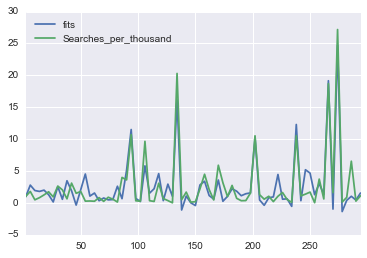

In [95]:
inner_2015[['fits','Searches_per_hundred']].plot()

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


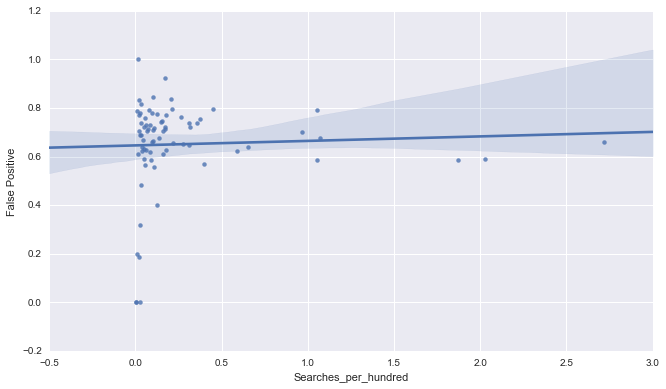

In [322]:
sns.lmplot(data=inner_2015,
           x='Searches_per_hundred',
           y='False Positive',
           size=5.5,
           aspect=1.7
          )

In [319]:
inner_2015[inner_2015['Searches_per_hundred']>0.5].set_index('LAC')[['False Positive','Searches_per_hundred']]#.describe()

,False Positive,Searches_per_hundred
LAC,,
EASTERN SUBURBS,0.675159,1.071416
FLEMINGTON,0.702627,0.965930
KINGS CROSS,0.589527,2.029761
MARRICKVILLE,0.623053,0.590834
NEWTOWN,0.583979,1.052717
REDFERN,0.791745,1.054735
SURRY HILLS,0.587473,1.869876
CITY CENTRAL,0.660550,2.718317
TWEED/BYRON,0.639896,0.654132


In [315]:
inner_2015['False Positive'].describe()

count    74.000000
mean      0.650934
std       0.188127
min       0.000000
25%       0.618999
50%       0.696141
75%       0.751525
max       1.000000
Name: False Positive, dtype: float64

In [321]:
inner_2015['False Positive'].median()

0.6961409070324125

/Users/jmacdonald/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)
/Users/jmacdonald/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


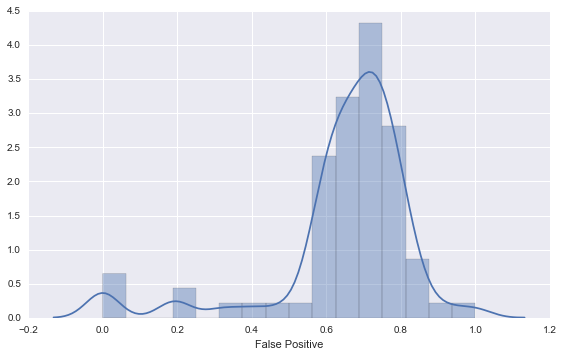

In [303]:
plt.figure(figsize=(5.5*1.7,5.5))
sns.distplot(inner_2015['False Positive'])